In [1]:
with open('input.txt', 'r' , encoding = 'utf-8') as f:
    text = f.read()
    

In [2]:
print('length of the dataset:' , len(text))

length of the dataset: 1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
#here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
#tokenizing strategy - raw text --> sequence of integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take string, output int
decode = lambda l: ''.join([itos[i] for i in l])#decoder: take a list of integers, output a string

In [6]:
# itos,stoi

In [7]:
print(encode('hi there'))

[46, 47, 1, 58, 46, 43, 56, 43]


In [8]:
# open AI uses tiktoken which instead of having 65 posisble chars
# has around 50K chars to encode

In [9]:
# tokenizing the entire dataset

In [10]:
import torch
data = torch.tensor(encode(text), dtype = torch.long)
print(data.shape, data.dtype)
# print(data[:1000])

torch.Size([1115394]) torch.int64


In [11]:
print(data[:10])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [12]:
#splitting the dataset into train and test split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [13]:
train_data

tensor([18, 47, 56,  ..., 43, 56, 43])

In [14]:
val_data

tensor([12,  0,  0,  ..., 45,  8,  0])

In [15]:
# note we won't bt inputting the whole datset into the transformer
# all at once because that would be computationally very expensice

In [16]:
# we train random chunks instead

In [17]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [18]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input context is {context} the target is: {target}")

when input context is tensor([18]) the target is: 47
when input context is tensor([18, 47]) the target is: 56
when input context is tensor([18, 47, 56]) the target is: 57
when input context is tensor([18, 47, 56, 57]) the target is: 58
when input context is tensor([18, 47, 56, 57, 58]) the target is: 1
when input context is tensor([18, 47, 56, 57, 58,  1]) the target is: 15
when input context is tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
when input context is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


In [19]:
x

tensor([18, 47, 56, 57, 58,  1, 15, 47])

In [20]:
y

tensor([47, 56, 57, 58,  1, 15, 47, 58])

In [21]:
torch.manual_seed(1337) # random location from the text bunch
batch_size = 4 # how many independent sequences will we process in parll
block_size = 8 # maximum context length

def get_batch(split):
    #generate small batch of data of inputs x and target y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    #random off sets in the training set
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

xb,yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): #batch_dims
    for t in range(block_size):# time dims
        context = xb[b,:t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

#### NOTE : this 4,8 array contains total of 32 examples and they are completely independent as far as transformer is concerned. For ex when input is [24, 43] the target is [58] etc. These are 32 indpendent examples packed in a single batch of the input x, and then the desired targets in y. 

In [22]:
print(xb)# our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [23]:
#let's start with bigram model

In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramModel(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        #each token directlly read off the logits for the next token from
        # a look table
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)
        #
    def forward(self,idx,targets): # x--> idx
        #idx and target are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        loss = F.cross_entropy(logits,targets) # -ve log likelihood
        
        return logits,loss

### Self.token_embedding_table: it is of size vocab_size, vocab_size and we are using nn.Embedding which is a very thin wrapper around tensor of shape (vocab_size, vocab_size). So, when we pass [idx] at logits = self.token_embedding_table(idx), every single integer in our input is going to refer to that embedding table and is goind to pluck out a row of that embedding table, corresponding to its index. So, 24 here will pluck out the 24th row and then 43 will pluck the 43rd row etc. And then pytorch is going to arrange all of this into (B)atch, (T)ime, (C)hannels tensor. So, batch is 4, time is 8 and C is vocab_size or 65. So, we are going to pluck out all those rows and arange them in (B,T,C) and now going to interpret as logits which are basically the scores for the next character in the sequence 

In [25]:
m = BigramModel(vocab_size)
out,loss = m(xb,yb)
print(out.shape)

RuntimeError: Expected target size [4, 65], got [4, 8]

In [26]:
# this error is because the F.cross_entropy expects (B,C,T) instead of (B,T,C)

In [29]:
#batch B
# Time T
# channel C 


In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramModel(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        #each token directlly read off the logits for the next token from
        # a look table
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)
        
    def forward(self,idx,targets=None):
        logits = self.token_embedding_table(idx) # (B,T,C)
        if targets is None:
            loss = None
            
        else:
        #idx and target are both (B,T) tensor of integers
            

            B,T,C = logits.shape
            logits = logits.view(B*T,C) # 2d-arr streching out the arr
            targets = targets.view(B*T) # 1D

            loss = F.cross_entropy(logits,targets)

        return logits,loss
    
    #generation
    def generate(self,idx,max_new_tokens):
        #idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            #get the predictions
            logits,loss = self(idx)
            #focus only on the last time step
            logits = logits[:,-1,:] # becomes B,C
            # -1 pluck out the  -1 or the last one in time dims
            # bc those are the predictions for what comes next 
            probs = F.softmax(logits, dim = -1) # (B,C)
            #sample from the distribution
            idx_next = torch.multinomial(probs,num_samples=1) # (B,1)
            #append sampled index to the running sequence
            idx = torch.cat((idx,idx_next), dim=1) # (B,T+1)
        return idx

m = BigramModel(vocab_size)
out,loss = m(xb,yb)
print(out.shape)
print(loss)
idx = torch.zeros((1,1), dtype = torch.long)
print(decode(m.generate(torch.zeros((1,1), dtype = torch.long), max_new_tokens = 100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [27]:
# recap - we are expected to have init loos asz -ln(1/vocab_size) i.e. 4.17
#this tell that the intial predictions arenot super good and we need a lil 
# more entropy

In [28]:
# m = BigramModel(vocab_size)
# out,loss = m(xb,yb)
# print(out.shape)
# print(loss)
# idx = torch.zeros((1,1), dtype = torch.long)
# print(decode(m.generate(torch.zeros((1,1), dtype = torch.long), max_new_tokens = 100)[0].tolist()))

In [29]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [30]:
batch_size = 32
for steps in range(10000):
    
    xb,yb = get_batch('train')
    
    logits,loss = m(xb,yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
print(loss.item())
    

2.382369041442871


In [31]:
print(decode(m.generate(torch.zeros((1,1), dtype = torch.long), max_new_tokens = 500)[0].tolist()))


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


In [32]:
#tokens are not talking to each other in bigram models

# self-attention trick

In [33]:
#consider the follwing toy example
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [34]:
x

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

In [35]:
x[0,:1] # note how at this time step we pluck out first row 

tensor([[ 0.1808, -0.0700]])

# some more insight prelim

In [36]:
# we want x[b,t] = mean_{i<=t} x[b,i]
#v1
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        
        xprev = x[b,:t+1] # (t,C)
#         print(f'xprev = b[{b}:{t+1}]: \n', xprev)
        
        xbow[b,t] = torch.mean(xprev,0) # averageing out the tth dims
        # i.e., we are average out by column
        
        

In [37]:
x[0] # note the first row is same as xbow because mean over one samplee

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [38]:
xbow[0]## note the first row is same as xbow because mean over one samplee

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [39]:
# this is very ineff using for loop

In [40]:
# let's use matrix mult to make it more eff

In [41]:
torch.manual_seed(42)
a = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('----')
print('b=')
print(b)
print('----')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
----
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
----
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [42]:
# THE TRICK is to use torch.tril


In [43]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [44]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a,1, keepdim = True)# this gives us the average
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('----')
print('b=')
print(b)
print('----')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
----
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
----
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


## Destroying the for loop

In [45]:
print(B,T,C)

4 8 2


In [46]:
wei = torch.tril(torch.ones(T,T))
wei = wei/ wei.sum(1,keepdim = True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [47]:
#v2
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1,keepdim = True)
xbow2 = wei @ x # (T,T) @ (B,T,C) --> batched mult (B,T,C) == xbow
# so (T,T) @ (T,C) will happen B times in parallel cus @ is batched mult

In [48]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [49]:
torch.allclose(xbow,xbow2) # comparing the two and proving they are =

True

### Another version - v3 using softmax

In [50]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T,T)
wei = wei.masked_fill(tril == 0, float('-inf'))
# the future cannot communicate with the past
wei = F.softmax(wei,dim = 1)
xbow3 = wei @ x
torch.allclose(xbow,xbow3)

True

In [51]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [52]:
wei = torch.zeros(T,T)

In [53]:
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [54]:
wei = wei.masked_fill(tril ==0, float('-inf'))

In [55]:
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [56]:
wei = F.softmax(wei,dim=1) # softmax along row

In [57]:
wei # same averaged triangular matrix 

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [58]:
# NOTE we got the same matrix bro!

In [59]:
# hence proved v1 == v2 == v3

# crux of Self-attention

In [60]:
#v4: self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32 # note the change of channels from 4 C = B*T
x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T,T))
# we don't want tril to be all uniform
# because diff tokens will find diff tokens more/less interesting
# and we want that to be data dependent [notes: self-attention]

wei = torch.zeros((T,T)) # affinities 
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei,dim=1)
out = wei @ x 

out.shape


torch.Size([4, 8, 32])

In [61]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [62]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

## Query and Key Implementation within our simple concept

In [63]:
# single head of self-attention
#v4: self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

#let's see a single Head perform self-attention
head_size = 16 # hyperparameter 
key = nn.Linear(C, head_size, bias = False) # just simple mat mul
query = nn.Linear(C, head_size, bias = False)
k = key(x) # (B,T,16) == x(B,T,C) * k(C,head_size)
q = query(x) # (B,T,16) == x(B,T,C) * q(C,head_size)

wei = q @ k.transpose(-2,-1) # (B,T,16) * (B,16,T) --> (B,T,T) 

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei,dim=2) # along the row or use -1 
out = wei @ x 

out.shape


torch.Size([4, 8, 32])

In [64]:
wei.shape

torch.Size([4, 8, 8])

In [65]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

In [66]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

In [67]:
# single head of self-attention
#v4: self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

#let's see a single Head perform self-attention
head_size = 16 # hyperparameter 
key = nn.Linear(C, head_size, bias = False) # just simple mat mul
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)
k = key(x) # (B,T,16) == x(B,T,C) * k(C,head_size)
q = query(x) # (B,T,16) == x(B,T,C) * q(C,head_size)


wei = q @ k.transpose(-2,-1) # (B,T,16) * (B,16,T) --> (B,T,T) 

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei,dim=2) # along the row or use -1 
v = value(x)  # (B,T,16) == x(B,T,C) * v(C,head_size)

out = wei @ v
# out = wei @ x

out.shape


torch.Size([4, 8, 16])

In [68]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

- Attention is a <b> communication mechanism </b> Can be seen as nodes in a directed graph looking at each other and aggre

- Attention is a <b> communication mechanism </b> where you have a number of nodes in a directed graph where you have edges pointing between nodes like figure 1. And what happens is, every node has some vector of information in it and it gets to aggregate information via a weighted sum from all nodes that point to it. And this is done in a data dependent manner. Our graph does not look like figure 1 tho. We have right nodes (block_size) an the first node is only pointing to itself, the second node is pointed to by the first node and itself, all the way upto the eighth node which is pointed to by all the previous nodes and itself. It has an autoregressive like kind of structure to it. It is just a communcation mechanism. 
- Notice that there is no notion of space. So, attention simply acts as a set of vectors in the graph. And so by default these nodes have no idea where they positioned in the space and that's why we have to encode them <b> positionally </b> and give them some information that anchors to a specific postion so that they know 'Where They Are'. And this is different from convolution. For example if you run a conv opertaion on some kind of input there is a very specific layout of the information in space and the convolutional filter acts in space and so it's not like an attention. Attention is just a set of vectors out there in space, they communicate and if you want to have a notion of 'space' you need to specifically add it. 
- The elements across the batch dims are independent examples and they never talk to each other they are always processed independently.
- In the case of language modelling we have a specific structure directed graph where the future token will not communicate with the past tokens. This necessarily does not have to be the case. You can have the future tokens talk to each other for example in sentiment analysis: you might have number of tokens and you may want to have them all talk to each other because later you are predicting the sentiment of the sentence and its okay for these nodes to talk to each other. And so in those cases you will use an "encoder" block of self-attention i.e., you will delete <b> wei = wei.masked_fill(tril == 0, float('-inf')) </b> this line of code allowing all the nodes to completely talk to each other . But if we keep it, what we are doing here is making a "decoder block" and it's called decoder becaues it is decoding language and it got this autoregressive format where you have to mask it triangularly so that nodes from the future never talk to the past because that would 'Give Away the Answer'. 
- 'Self-Attention': There also something called cross-attention, the reason the above code block is self-attention, is because they key, query and the values are all coming from the same source from 'x'. So, the same source 'x' uses key,queries and values. So, these nodes are 'Self-Attending'. But in principal, attention is more general than that . For example, in encoder-decoder transformers, you can have a case where the queries are produced from 'x' but the keys and the values, come from a whole sepereate different external source and sometimes from encoder blocks that encodes some context that we want to condition on. So, the keys and the vals will come from a totally different source those are nodes on the side, and here we are just producing queries and we are reading off infromation from the side. So, cross-attention is used when there is a seperate source of nodes we like to pool infromation from to our nodes.  

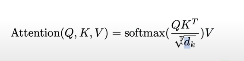

- If we go back to 'Attention is All you Need' paper, we implemented attention properly but there is also a sqrt(dk) i.e., the head_size. Why are they doing this? 'They' call it the scaled attention. And it is kind of important normalization to have. The problem is, when you have unit gaussian inputs, (0 mean, 1 unit variance), k and q are unit gaussian and you mult and cal wei naively, then you see that your wei.var() actally will be on the order of head_size <b> 16.1035 </b>. But if you multiply by 1/(sqrt(head_size)) . Then the wei_normed.var() will be <b> one </b> so it will be preserved. Why is this important? Notice that wei will feed into softmax and it is really important especially in translation, that wei be fairly diffused. So, in our case here ref to figure 2, wei[0] had fairly diffused numbers here . But the problem is that because of softmax, if the wei takes on very positive and negative values, softmax will actually converge towards <b> One-Hot-Vectors </b> Illustrated below

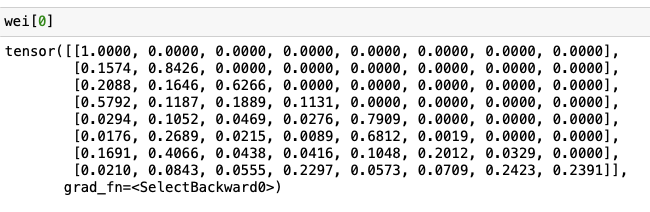 <b> Figure 2. </b>

### Not Normed

In [69]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) #* head_size**(0.5)

In [70]:
k.var()

tensor(1.0449)

In [71]:
q.var()

tensor(1.0700)

In [72]:
wei.var()

tensor(17.4690)

### Illustraiton 

- Note: in the first example, the values are relatively diffused, but in the second we are sharpening it and you see that the softmax also starts sharpening and you see that it will sharpen towards the max, and it will sharpen to whatever number in the vector is highest. And we don't want these values to be too extreme especially, at the intialiazation otherwise the softmax will be way to peaky and you are basically aggreagating information from like a single node - and this is what we don't want. Hence, the <b>scaling</b> is used to control the variance, at initialization.

In [73]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5]), dim = -1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [74]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5])*8, dim = -1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

### Normed

In [75]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) * head_size**(-0.5)

In [76]:
k.var()

tensor(0.9006)

In [77]:
q.var()

tensor(1.0037)

In [78]:
wei.var()

tensor(0.9957)

In [79]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5]), dim = -1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

### Taking our self-attention node for a spin on Visual Studio v2.py

# Multi Head Attention 
- It is just concat of single head attention 
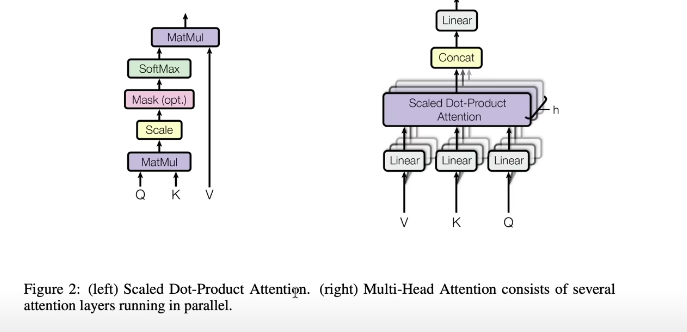

In [100]:
# Batch Norm Implementaation for Transformer

class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        
        self.eps = eps 
        self.beta = torch.zeros(dim)
        self.gamma = torch.ones(dim)
       
   


    def __call__(self,x):
        #calculate forward pass
       
        xmean = x.mean(0,keepdim = True) # batch mean
        xvar = x.var(0,keepdim = True) # batch var

        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # norm unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        
        return self.out
        
    def parameters(self):
        return (self.gamma, self.beta)
    
torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32,100) # batch size is 32 of 100 dims vectors
x = module(x)
x.shape

torch.Size([32, 100])

- First Column : 0 mean and unit var perfecto!

In [101]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(1.4901e-08), tensor(1.0000))

- Rows don't normalize by default

In [102]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(0.0411), tensor(1.0431))

## Layer Norm - Very Complicated Implementation 
- Note: we want to norm the rows, okay? 

- To implement layer norm you just switch 
           - xmean = x.mean(0,keepdim = True) # batch mean
           - xvar = x.var(0,keepdim = True) # batch var 
            TO
            - xmean = x.mean(1,keepdim = True) # batch mean 0 to 1
           - xvar = x.var(1,keepdim = True) # batch var 0 to 1
            
           

In [96]:
# Layer Norm Implementaation for Transformer

class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        
        self.eps = eps 
        self.momentum = momentum
        self.training = True
        #parameters (trained with back prop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers )trainied witha rinning momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(1,keepdim = True) # batch mean, layer norm
            xvar = x.var(1,keepdim = True) # batch var, layer norm
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # norm unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out
        
    def parameters(self):
        return (self.gamma, self.beta)
    
torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32,100) # batch size is 32 of 100 dims vectors
x = module(x)
x.shape

torch.Size([32, 100])

- Note how the column are not normalized now 

In [97]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

- but the rows are normalize :') 

In [98]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))